# Surface Reconstruction

This is the code to generate the surface from our segmentation. It involves contructing the white matter surface marching cubes (1), using a laplacian like method from Ants to generate a velocity field (2), and displacing the wm surface up to the pial using the velocity fiel (3), claculate the exposed area (4), and then finally extract our measurements (5).

In [203]:
from src.surface import *
from src.helper import get_crop, apply_crop, apply_uncrop, crop_nifti
from src.direct import *

In [204]:
# PARAMETER CELL
NAME = "porpoise"
SRC_DIR = "out_HP1/"

In [205]:
out_dir = SRC_DIR + "/srf/" # where we save surfaces
mkdir(out_dir)
print(out_dir)

out_HP1//srf/


In [206]:
# load files
file = nib.load(os.path.join(SRC_DIR, "seg.nii.gz")) #
seg, affine = file.get_fdata().astype(np.float32), file.affine
crop = get_crop((seg > 0))
pixdim = file.header["pixdim"][1:4].tolist() # need voxel size for measurements

In [207]:
seg = crop_nifti(file, crop)
wm_prob = crop_nifti(nib.load(os.path.join(SRC_DIR, "wmprob.nii.gz")), crop)
gm_prob = crop_nifti(nib.load(os.path.join(SRC_DIR, "gmprob.nii.gz")), crop)
aparc = crop_nifti(nib.load(os.path.join(SRC_DIR, "softmax_seg.nii.gz")), crop).get_fdata()

(<matplotlib.image.AxesImage at 0x7faa135e3450>,
 <matplotlib.image.AxesImage at 0x7faa121a0850>)

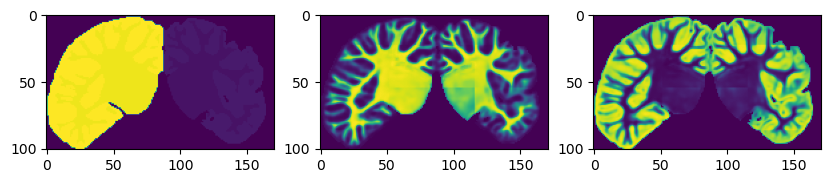

In [208]:
i = 60
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(aparc[i]), axs[1].imshow(wm_prob.get_fdata()[i]), axs[2].imshow(gm_prob.get_fdata()[i])

## 1. Contructing the WM

In [255]:
# we use the wm prob as level map
level = np.abs(0.5 - wm_prob.get_fdata())

In [256]:
# create wm surface
white_seg_lh = correct(clean_seg(aparc == 2), level)
white_lh = gen_mesh(white_seg_lh)
white_lh = trimesh.smoothing.filter_humphrey(white_lh)

In [257]:
# create wm surface
white_seg_rh = correct(clean_seg(aparc == 41), level)
white_rh = gen_mesh(white_seg_rh)
white_rh = trimesh.smoothing.filter_humphrey(white_rh)

In [258]:
#white_rh.show()

## 2. Create Velocity Field

In [259]:
wm_prob = crop_nifti(nib.load(os.path.join(SRC_DIR, "wmprobT.nii.gz")), crop)
gm_prob = crop_nifti(nib.load(os.path.join(SRC_DIR, "gmprobT.nii.gz")), crop)

In [260]:
if not os.path.exists(os.path.join(SRC_DIR, "ForwardVelocityField.nii.gz")):
    # run DiReCT (KellyKapowski), equivalent to
    #     KellyKapowski -d 3 -s ${DST}/seg.nii.gz -g ${DST}/gmprobT.nii.gz -w ${DST}/wmprobT.nii.gz -o ${THICK_VOLUME} -c "[ 45,0.0,10 ]" -v
    thick = nifti_to_ants(wm_prob)
    
    kelly_kapowski(s=nifti_to_ants(seg), 
                   g=nifti_to_ants(gm_prob), 
                   w=nifti_to_ants(wm_prob), 
                   c='[ 45,0.0,10 ]', v='1', o=[thick, SRC_DIR+"/"]) # we have to add spacing to account for early convergence criteria
    
    # Check thickness is not still all zeros
    if thick.sum() == 0.0:
        raise RuntimeError("KellyKapowski failed to compute thickness")

    save_img(thick.numpy(), SRC_DIR, 'Thickmap', wm_prob) # by default we don't uncrop thickness maps
else:
    print("Found velocity field, skipping DiReCT! Make sure it's in the same space as the points!")

Found velocity field, skipping DiReCT! Make sure it's in the same space as the points!


## 3. Pial Surface Reconstruction

In [261]:
# DiReCT deformation Field    
def apply_deformation(points, def_field, step_size=0.1, order=1, pixdim=[1, 1, 1]):
    
    points = points.copy()
    thickness = np.zeros(len(points))
    
    for i in range(0, 10, 1):
        vx = def_field[ :, :, :, i, 0]
        vy = def_field[ :, :, :, i, 1]
        vz = def_field[ :, :, :, i, 2]

        for j in np.arange(0, 1, step_size):
            v = np.array([
                scipy.ndimage.map_coordinates(vx, points.T, order=order),
                scipy.ndimage.map_coordinates(vy, points.T, order=order),
                scipy.ndimage.map_coordinates(vz, points.T, order=order)
            ]).T

            points += (step_size * v)
            thickness +=  np.linalg.norm(step_size * v * pixdim, axis=1) # multiply by pixel dimensions

        print(".", end="", flush=True)
        
    return points, thickness

In [263]:
velocity_field = nib.load(os.path.join(SRC_DIR, "ForwardVelocityField.nii.gz")).get_fdata().astype(np.float32)

In [264]:
vertices_lh, lh_thick = apply_deformation(white_lh.vertices.copy(), velocity_field, pixdim=pixdim, order=2) # pixdim has to be chosen
pial_lh = trimesh.Trimesh(vertices=vertices_lh, faces=white_lh.faces)
pial_lh = trimesh.smoothing.filter_humphrey(pial_lh)

........

In [265]:
vertices_rh, rh_thick = apply_deformation(white_rh.vertices.copy(), velocity_field, pixdim=pixdim, order=2)
pial_rh = trimesh.Trimesh(vertices=vertices_rh, faces=white_rh.faces)
pial_rh = trimesh.smoothing.filter_humphrey(pial_rh)

........

In [1]:
pial_lh.show()

## 4. Exposed Surface

We first calculate the convex mesh 

In [228]:
convex_lh = trimesh.convex.convex_hull(pial_lh)

In [229]:
convex_rh = trimesh.convex.convex_hull(pial_rh)

In [230]:
convex_rh.show()

We then calculate the 2d slice to reconstruct the surface

In [231]:
exp_lh = rolling_ball(clean_seg((aparc == 2) | (aparc == 3)).astype(int), ball_diameter=15, pixdim=pixdim[0])
exp_lh = trimesh.smoothing.filter_laplacian(gen_mesh2(exp_lh), lamb=1, iterations=20)

In [232]:
exp_rh = rolling_ball(clean_seg((aparc == 41) | (aparc == 42)).astype(int), ball_diameter=15, pixdim=pixdim[0])
exp_rh = trimesh.smoothing.filter_laplacian(gen_mesh2(exp_rh), lamb=1, iterations=20)

In [2]:
exp_rh.show()

Now, we will register the images to the orginal images, as well as extracing measurements

In [237]:
white_lh = register(white_lh, file, out_dir  + '/lh.white', translate=crop[0])
pial_lh = register(pial_lh, file, out_dir  + '/lh.pial', translate=crop[0])
exp_lh = register(exp_lh, file, out_dir  + '/lh.exp', translate=crop[0])
convex_lh = register(convex_lh, file, out_dir  + '/lh.convex', translate=crop[0])

In [238]:
white_rh = register(white_rh, file, out_dir  + '/rh.white', translate=crop[0])
pial_rh = register(pial_rh, file, out_dir  + '/rh.pial', translate=crop[0])
exp_rh = register(exp_rh, file, out_dir  + '/rh.exp', translate=crop[0])
convex_rh = register(convex_rh, file, out_dir  + '/rh.convex', translate=crop[0])

## 5. Extract Measurements

### From Surface

Here we extract the measurements directly from the surface

In [239]:
volume_measurements = {
    "lh.white_volume": white_lh.volume,
    "lh.pial_volume": pial_lh.volume,
    "lh.gm_volume": (pial_lh.volume - white_lh.volume),
    "lh.exp_volume": exp_lh.volume,
    "lh.convex_volume": convex_lh.volume,
    
    "rh.white_volume": white_rh.volume,
    "rh.pial_volume": pial_rh.volume,
    "rh.gm_volume": (pial_rh.volume - white_rh.volume),
    "rh.exp_volume": exp_rh.volume,
    "rh.convex_volume": convex_rh.volume,
}

In [240]:
surface_measurements = {
    "lh.white_surface": white_lh.area,
    "lh.pial_surface": pial_lh.area,
    "lh.exp_surface": exp_lh.area,
    "lh.convex_surface": convex_lh.area,
    
    "rh.white_surface": white_rh.area,
    "rh.pial_surface": pial_rh.area,
    "rh.exp_surface": exp_rh.area,
    "rh.convex_surface": convex_rh.area,
}

In [241]:
thickness_measurements = {
    "lh.mean_thickness": (pial_lh.volume - white_lh.volume) / pial_lh.area,
    "rh.mean_thickness": (pial_rh.volume - white_rh.volume) / pial_rh.area,
}

In [242]:
df = pd.DataFrame([{**volume_measurements, **surface_measurements, **thickness_measurements}], index=[NAME])
df.to_csv(SRC_DIR + "/results_surf.csv")
df

,lh.white_volume,lh.pial_volume,lh.gm_volume,lh.exp_volume,lh.convex_volume,rh.white_volume,rh.pial_volume,rh.gm_volume,rh.exp_volume,rh.convex_volume,lh.white_surface,lh.pial_surface,lh.exp_surface,lh.convex_surface,rh.white_surface,rh.pial_surface,rh.exp_surface,rh.convex_surface,lh.mean_thickness,rh.mean_thickness
porpoise,86323.665505,204448.183193,118124.517687,228276.452386,242848.336475,88276.484535,213621.143193,125344.658658,227279.142899,240655.217643,47428.879486,35445.037441,20571.942379,20332.627083,47827.640887,32806.40331,19900.383898,19888.04793,3.332611,3.820738


### From DiReCT

In [243]:
v = np.prod(pixdim) # volume of a voxel

volume_measurements = {
    "lh.white_volume": (aparc == 2).sum() * v, # 2, Left-Cerebral-White-Matter
    "lh.gm_volume": (aparc == 3).sum() * v, # 3, Left-Cerebral-Cortex (1000)
    
    "rh.white_volume": (aparc == 41).sum() * v, # 41, Right-Cerebral-White-Matter
    "rh.gm_volume": (aparc == 42).sum() * v, # 42, Right-Cerebral-Cortex (2000)
}
volume_measurements

{'lh.white_volume': 86890.0739774108,
 'lh.gm_volume': 120337.56801858544,
 'rh.white_volume': 88970.51505744457,
 'rh.gm_volume': 120921.23409733176}

In [244]:
# make sure to have adjusted for voxel size in our input! 
thickness_measurements = {
    "lh.mean_thickness_direct": lh_thick[lh_thick > 0].mean(),
    "lh.sd_thickness_direct": lh_thick[lh_thick > 0].std(),
    
    "rh.mean_thickness_direct": rh_thick[rh_thick > 0].mean(),
    "rh.sd_thickness_direct": rh_thick[rh_thick > 0].std(),
}
thickness_measurements

{'lh.mean_thickness_direct': 6.018202254152495,
 'lh.sd_thickness_direct': 3.366864608050721,
 'rh.mean_thickness_direct': 6.614749818670718,
 'rh.sd_thickness_direct': 3.476395266304465}

In [245]:
# Save point-wise thickness estimates
nib.freesurfer.io.write_morph_data(out_dir + "/lh_thickness_direct", lh_thick, fnum=0)
nib.freesurfer.io.write_morph_data(out_dir + "/rh_thickness_direct", rh_thick, fnum=0)

In [246]:
# FreeSurfer dfinition of thickness
thickness_fs_lh = get_freesurfer_distance(white_lh, pial_lh)
thickness_fs_rh = get_freesurfer_distance(white_rh, pial_rh)

thickness_measurements_fs = {
    "lh.mean_thickness_fs": thickness_fs_lh[thickness_fs_lh > 0].mean(),
    "lh.sd_thickness_fs": thickness_fs_lh[thickness_fs_lh > 0].std(),
    
    "rh.mean_thickness_fs": thickness_fs_rh[thickness_fs_rh > 0].mean(),
    "rh.sd_thickness_fs": thickness_fs_rh[thickness_fs_rh > 0].std(),
}
thickness_measurements_fs

{'lh.mean_thickness_fs': 3.1136067027160412,
 'lh.sd_thickness_fs': 1.7118097061968218,
 'rh.mean_thickness_fs': 3.3428523213012094,
 'rh.sd_thickness_fs': 1.7152435359242026}

In [247]:
# Save point-wise thickness estimates
nib.freesurfer.io.write_morph_data(out_dir + "/lh_thickness_fs", thickness_fs_lh, fnum=0)
nib.freesurfer.io.write_morph_data(out_dir + "/rh_thickness_fs", thickness_fs_rh, fnum=0)

In [248]:
df = pd.DataFrame([{**volume_measurements, **thickness_measurements, **thickness_measurements_fs}], index=[NAME])
df.to_csv(SRC_DIR + "/results_direct.csv")
df

,lh.white_volume,lh.gm_volume,rh.white_volume,rh.gm_volume,lh.mean_thickness_direct,lh.sd_thickness_direct,rh.mean_thickness_direct,rh.sd_thickness_direct,lh.mean_thickness_fs,lh.sd_thickness_fs,rh.mean_thickness_fs,rh.sd_thickness_fs
porpoise,86890.073977,120337.568019,88970.515057,120921.234097,6.018202,3.366865,6.61475,3.476395,3.113607,1.71181,3.342852,1.715244
